## Introduction

Welcome back to the third blog post in the Python for Beginners series!

In this blog post, I’m going to walk you through how I built a web scraper using Scrapy to extract and analyze movie cast data from The Movie Database (TMDB).

### Setting Up the Project

#### Pick Your Favorite Movie
Start off with picking your favorite movie and find its TMDB page by searching on https://www.themoviedb.org/. For this tutorial, we will be choosing: https://www.themoviedb.org/movie/671-harry-potter-and-the-philosopher-s-stone/
- *Save this URL for now.*

#### Walk Through Before Coding
Before jumping into coding, it’s important to understand the navigation steps our scraper will take. This helps us to make sure that we are targeting the right elements and URLs. Manually click through the site and try to find a structure of the web pages we need to scrape.

**Steps:**

1. Start on a movie’s main page and locate the Full Cast & Crew link. Click it.

2. Observe that the URL now follows the pattern <original_url>/cast/.

3. Scroll to the Cast section and click on an actor’s profile picture.

4. This leads to an actor-specific page with a URL like https://www.themoviedb.org/person/4566-alan-rickman.

5. Scroll down to the Acting section and take note of movie and TV show titles listed.

#### Initialize Your Project
In your terminal, write the following lines to initialize your project:

In [ ]:
conda activate PIC16B-25W
scrapy startproject TMDB_scraper
cd TMDB_scraper

#### Tweak Settings for Efficient Scraping
Before running our scraper, we need to make a small tweak in the Scrapy settings to prevent excessive data collection during testing. Open settings.py and add the following line:

In [ ]:
CLOSESPIDER_PAGECOUNT = 20

This will make sure that our scraper stops after processing 20 pages, allowing us to check that everything is working correctly without being overwhelming to our system. Once we’re okay with the scraper’s behavior, we can remove this limit.

#### Avoiding 403 Forbidden Errors
As we start making automated requests, TMDB may detect that we are using a scraper and block our requests, resulting in a 403 Forbidden error. This happens when the website identifies that a bot (rather than a human) is making the requests. A simple workaround is modifying the User-Agent in settings.py to mimic a real browser.

Run the following command in Terminal:

In [ ]:
scrapy shell -s USER_AGENT='Scrapy/2.8.0 (+https://scrapy.org)' https://www.themoviedb.org/...

### Implementing the Scraper
Our first step is creating a new Python file: inside the tmdb_scraper/spiders/ directory, create a new Python file called tmdb_spider.py to implement our scraper.

Our scraper will work in three main steps which we will implement in functions:

1. First, it will parse the main movie page which will extract the URL for the full cast page.

2. Then, it will parse the full credits page which will extract actor links.

3. And finally, it will parse actor pages which will then extract the actor’s name and the list of movies they have acted in.

#### 1. Parsing the Main Movie Page (parse Method)

The scraper starts by navigating to a movie’s main page. From here, it constructs a URL to the full cast and crew page and sends a request to parse it.

In [ ]:
def parse(self, response):
        """
        Parses the movie page and navigates to the Full Cast & Crew page.

        Yields:
            scrapy.Request: A request to the Full Cast & Crew page, calling 'parse_full_credits'.
        """
        # Hardcoding the path to the Full Cast & Crew page
        full_cast_url = response.url + "/cast"
    
        # Yield a request to the full credits page, calling parse_full_credits
        yield scrapy.Request(full_cast_url, callback=self.parse_full_credits)

#### 2. Parsing the Full Credits Page (parse_full_credits Method)

Once on the full cast and crew page, we extract all actor profile links (ignoring crew members) and send requests to each actor's page.

In [ ]:
def parse_full_credits(self, response):
        """
        Extracts actor links from the Full Cast & Crew page and navigates to each actor's page.

        Args:
            response: The HTTP response for the Full Cast & Crew page.
        
        Yields:
            scrapy.Request: Requests for each actor's page, using `parse_actor_page` as the callback.
        """
        # Select actor links while excluding crew members
        actor_links = response.xpath("//ol[contains(@class, 'people credits ')]/li[not(contains(@class, 'people credits crew')) and not(ancestor::div[contains(@class, 'crew_wrapper')])]/a[@href]/@href").getall()
        
        # Yield requests for actor pages, using `parse_actor_page` as the callback
        for link in actor_links:
            full_url = response.urljoin(link)  
            yield scrapy.Request(url=full_url, callback=self.parse_actor_page)

#### 3. Parsing the Actor Page (parse_actor_page Method)

On the actor’s page, we extract their name and list of movies/TV shows they’ve appeared in.

In [ ]:
def parse_actor_page(self, response):
        """
        Extracts actor information and acting credits from the actor's page.

        Args:
            response: The HTTP response for the actor's page.

        Yields:
            dict: A dictionary containing the actor's name and a unique movie/TV name.
        """
        # Extract actor's name from the page header
        actor_name = response.css('h2.title a::text').get()
        if actor_name:
            actor_name = actor_name.strip()
        else:
            return

        # Find the Acting section and extract movie/TV show titles
        acting_section = response.xpath("//h3[contains(text(), 'Acting')]/following-sibling::table[1]")
        if not acting_section:
            return
        movie_titles = acting_section.xpath(".//bdi/text()").getall()

        # Remove duplicate titles using a set
        unique_titles = set(movie_titles)

        # Yield a dictionary for each unique movie/TV show
        for title in unique_titles:
            yield {
                "actor": actor_name,
                "movie_or_TV_name": title.strip()
            }

### Running the Scraper

To run the scraper, use the following command in the Terminal:

In [ ]:
scrapy crawl tmdb_spider -o results.csv -a subdir=671-harry-potter-and-the-philosopher-s-stone

*Feel free to use a "subdir" of your choice! This is just an example using Harry Potter and the Philosopher's Stone.*

This will scrape the cast data for Harry Potter and the Philosopher’s Stone and save the results to results.csv.

### Results
After running the recommendation system, I decided to create a simple but intuitive dataframe to find which movies and TV shows share the most actors with our target film.

Import libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
from collections import defaultdict

Create a data frame that has two columns: Movie/TV Name and Number of Actors Shared:

In [2]:
# Convert the scraped data in the CSV file to a data frame
results = pd.read_csv("results.csv")

# Create a dictionary to count how many times each movie/TV show appears
# Key: Movie/TV show name, Value: Number of shared actors
movie_map = defaultdict(int)

# Iterate over each row in the results DataFrame
for index, row in results.iterrows():
    # Skip the target movie
    if row.at["movie_or_TV_name"] == "Harry Potter and the Philosopher's Stone":
        continue
    # Increment the count for the current movie/TV show
    movie_map[row.at["movie_or_TV_name"]]+=1

# Convert the dictionary into a data frame
shared_actors = pd.DataFrame(list(movie_map.items()), columns=['Movie/TV Name', 'Number of Shared Actors'])
# Sort the data frame
shared_actors = shared_actors.sort_values(by='Number of Shared Actors', ascending=False)

In [3]:
shared_actors

,Movie/TV Name,Number of Shared Actors
102,Harry Potter and the Chamber of Secrets,25
37,Harry Potter and the Prisoner of Azkaban,15
72,Harry Potter and the Deathly Hallows: Part 2,15
173,Doctor Who,12
53,Harry Potter and the Deathly Hallows: Part 1,12
...,...,...
564,Mo,1
565,Stepping Out,1
566,Artsnight,1
567,Bathtime,1


Using this data frame, create an intuitive visualization using Matplotlib

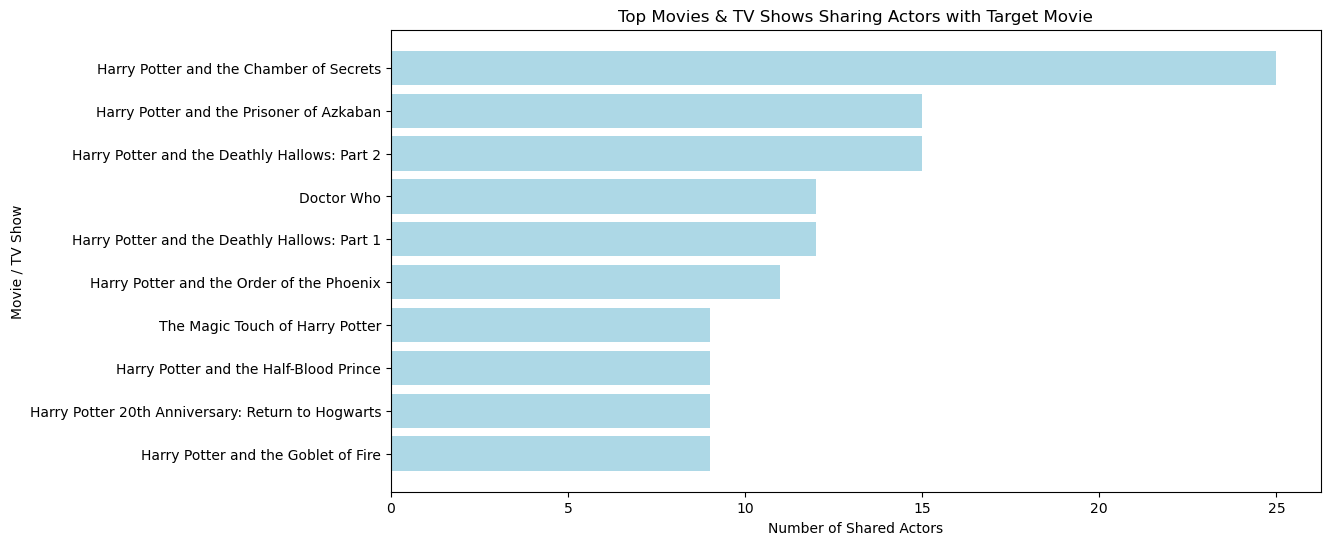

In [4]:
# Create bar chart
plt.figure(figsize=(12, 6))
plt.barh(shared_actors["Movie/TV Name"].head(10), shared_actors["Number of Shared Actors"].head(10), color="lightblue")  
plt.xlabel("Number of Shared Actors")  
plt.ylabel("Movie / TV Show")  
plt.title("Top Movies & TV Shows Sharing Actors with Target Movie")  
plt.gca().invert_yaxis()  
plt.show()  

### Conclusion
And that's it for this week's blog post! I hope you learned something about the basics of web scraping and hope to see you next week!